# Distracted Drivers Detection

I will start with pre-trained ResNet-34 and ResNet-50 (Transfer Learning)

### 1. Import the needed packages and specify the batch size that can be handeled with our GPU.

In [1]:
# To ensure that every edit I made to libraries are automatically reloaded here.
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# import necessary packages.
## I am working with the fastai V1 library which sits on top of Pytorch 1.0. 
import pandas as pd
import numpy as np
from shutil import move, copy
from fastai.vision import *
from fastai.metrics import error_rate, accuracy
from fastai.callbacks import *
#from fastai import *


In [3]:
#batch size that My GPU can handel
bs = 64

### 2. Loading State's Farm Distracted Drivers Dataset

In [6]:
# Dataset Path
path = untar_data('~/storage/5thMarch');
path.ls()

[PosixPath('/storage/5thMarch/models'),
 PosixPath('/storage/5thMarch/train'),
 PosixPath('/storage/5thMarch/driver_imgs_list.csv'),
 PosixPath('/storage/5thMarch/sample+resnet50.ipynb'),
 PosixPath('/storage/5thMarch/valid'),
 PosixPath('/storage/5thMarch/actualdata+samplevalid')]

In [5]:
# Remove checkpoints files
%cd '{path}'
!find '.' -name '.ipynb*' -exec rm -r {} +

/storage/5thMarch


### 3. Data Preprocessing

In [7]:
aug_tfms = get_transforms(do_flip=False, flip_vert=False)

In [100]:
doc(get_transforms)

In [8]:
### Resize Images to 224X224 and normalize them during creating the databunch
data2 = (ImageItemList.from_folder(path)
        .split_by_folder(train ='train', valid ='valid')
        .label_from_folder()
        .transform(tfms=aug_tfms, size=224)
        .databunch(bs=bs)).normalize(imagenet_stats)

In [9]:
# How many Images in each split? almost 20% of the training set moved to the validation set.

data2.classes, data2.c, len(data2.train_ds), len(data2.valid_ds)

(['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'], 10, 2274, 1034)

## 4. Looking at the Data

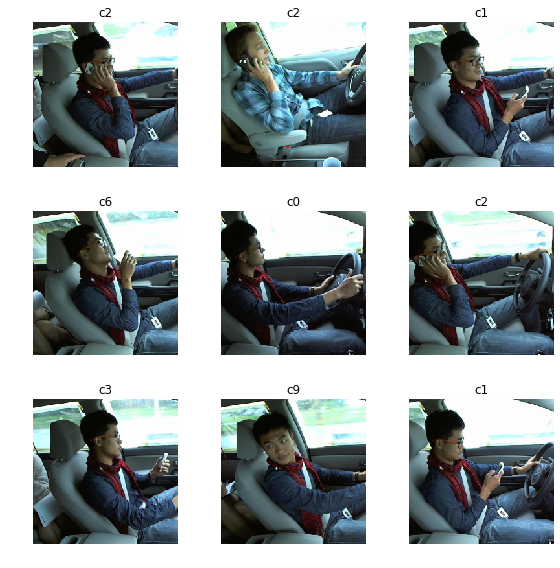

In [9]:
data2.show_batch(rows=3, figsize=(8,8))

Next, We made sure that we have kind of balanced dataset

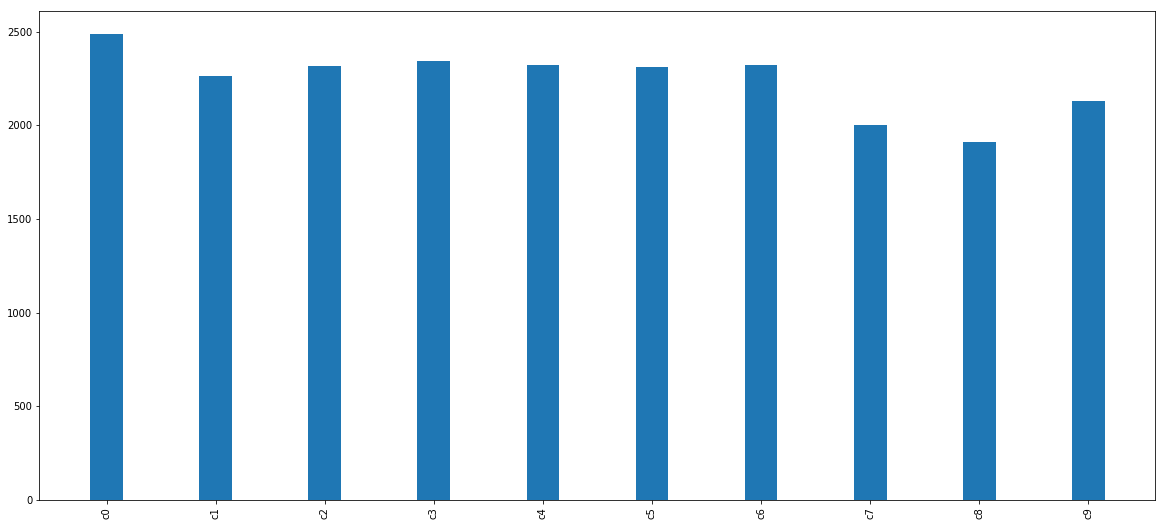

In [79]:
# Let's encode the labels
labels_map = {}
inv_labels_map = {}
count = 0
for label in driver_data['classname']:
    if(label in labels_map):
        continue
    labels_map[label] = count
    inv_labels_map[count] = label
    count = count + 1
# Let's check the distribution of the classes we have
labels_count = {}
for label in driver_data['classname']:
    if(label in labels_count):
        labels_count[label] = labels_count[label] + 1
    else:
        labels_count[label] = 0
# print(labels_count)
plt.figure(figsize=(20,9))
plt.bar(list(labels_count.keys()), list(labels_count.values()),width=0.3)
plt.xticks(rotation = 90)
plt.show()

## 5. Modeling

### 5.1 ResNet-34

Using pretrained model (trained on ImageNet with more than 1 million image and 1000 classes)

### Training

In [10]:
# Load the pre-trained model
learn = create_cnn(data2, models.resnet50, 
                   metrics=[accuracy, error_rate])

In [11]:
# Looking at the model structure
# output layer changes to give "out_features=10" matching out dataset total labels

learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0): Conv2d(64, 256, kernel_s

In [12]:
print(learn.summary())

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [1, 64, 112, 112]    9,408      False     
______________________________________________________________________
BatchNorm2d          [1, 64, 112, 112]    128        True      
______________________________________________________________________
ReLU                 [1, 64, 112, 112]    0          False     
______________________________________________________________________
MaxPool2d            [1, 64, 56, 56]      0          False     
______________________________________________________________________
Conv2d               [1, 64, 56, 56]      4,096      False     
______________________________________________________________________
BatchNorm2d          [1, 64, 56, 56]      128        True      
______________________________________________________________________
Conv2d               [1, 64, 56, 56]      36,864     False     
______________________________________________________________

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.02E-03


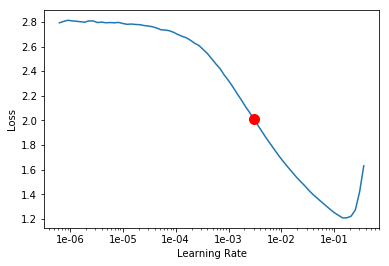

In [14]:
# Find best learning rate 
learn.lr_find()
learn.recorder.plot()

In [15]:
# There is a rule of thumb regarding the best Learning Rate by Jermey(Co-founder of Fastai)
# "start of the deepest slop before buttom should be the best Learning Rate = 10 times before the buttom"

lr = 3e-03

In [16]:
# By default this will train the last layers(that with random weights)assume the rest layers as non-trainable(Freezed)
# I will use epochs snapshots to save the weights of each epoch and I will pick the one that just seems right
# for my model

learn.fit_one_cycle(6, slice(lr))


epoch,train_loss,valid_loss,accuracy,error_rate
1,1.029734,2.402833,0.284333,0.715667
2,0.438552,2.436107,0.331721,0.668279
3,0.229460,2.601697,0.377176,0.622824
4,0.135335,2.681802,0.392650,0.607350
5,0.086339,2.534918,0.406190,0.593810
6,0.059388,2.472935,0.416828,0.583172


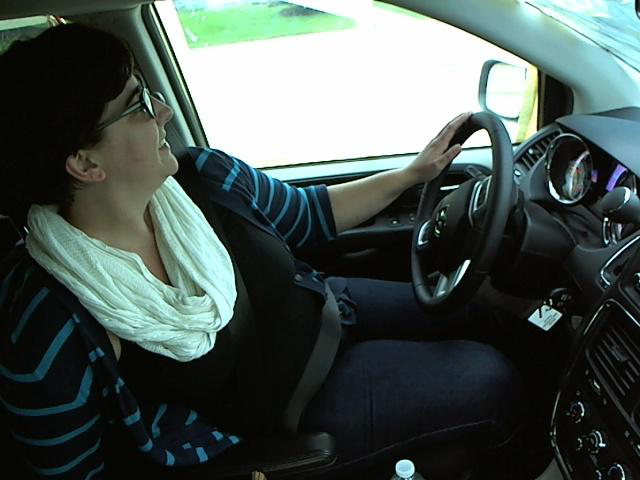

In [13]:
data2.valid_ds.x[0]

In [66]:
learn.unfreeze()

In [67]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.32E-06


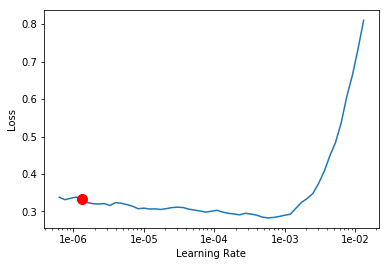

In [68]:
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,error_rate
1,0.149903,0.416864,0.849115,0.150884
2,0.078223,0.299294,0.899272,0.100728
3,0.047077,0.317065,0.893028,0.106972


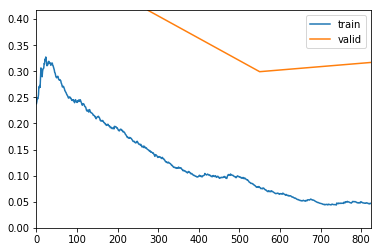

In [69]:
learn.fit_one_cycle(3, slice(1.3e-06,lr/10)